In [2]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                      config_dict='TPOT light')
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.971785763458626

Generation 2 - Current best internal CV score: 0.971785763458626

Generation 3 - Current best internal CV score: 0.971785763458626

Generation 4 - Current best internal CV score: 0.975497728211483

Generation 5 - Current best internal CV score: 0.975497728211483

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=7, p=1, weights=distance)
0.9822222222222222


In [5]:
type(digits.data[0])

numpy.ndarray

In [7]:
from numpy import genfromtxt
X = []
y = []
for i in range(1,101):
    my_data = genfromtxt(f'../../thesis/raw_data/Test/results{i}.txt', delimiter=',')[1:]
    temp_x = []
    temp_y = []
    for i in range(len(my_data)):
        temp_x.append(my_data[i][:4])
        temp_y.append(my_data[i][4])
    X.append(temp_x)
    y.append(temp_y)
y=np.array([np.array(xi) for xi in y])
X=np.array([np.array(xi) for xi in X])

In [12]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt"))))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
df

,curr_dens,Volts_tot,Temp_tot,t_tot,SOC_tot
0,-17.715577,3.728046,272.000000,0.0,34.000000
1,-17.715577,3.727801,272.003044,0.5,33.991582
2,-17.715577,3.727573,272.006279,1.0,33.983165
3,-17.715577,3.727355,272.009530,1.5,33.974747
4,-17.715577,3.727144,272.012796,2.0,33.966330
...,...,...,...,...,...
5543,8.920406,3.406472,317.898041,2771.5,3.757894
5544,23.201588,3.443712,317.888330,2772.0,3.768918
5545,23.201588,3.444352,317.878582,2772.5,3.779942
5546,23.201588,3.444985,317.868878,2773.0,3.790967


In [9]:
from tpot import TPOTRegressor

In [14]:
X=df.drop(columns=['SOC_tot'])
y = df.SOC_tot
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=False)

In [19]:
from fireTS.models import NARX, DirectAutoRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

# Random training data
#x = np.random.randn(100, 2)
#y = np.random.randn(100)
x= df.drop(columns=['SOC_tot'])
y = df.SOC_tot
# Build a non-linear autoregression model with exogenous inputs
# using Random Forest regression as the base model
mdl1 = NARX(
    RandomForestRegressor(n_estimators=10),
    auto_order=2,
    exog_order=[2,2],
    exog_delay=[1, 1])
mdl1.fit(x, y)
ypred1 = mdl1.predict(x, y, step=3)

# Build a general autoregression model and make multi-step prediction directly
# using XGBRegressor as the base model
mdl2 = DirectAutoRegressor(
    XGBRegressor(n_estimators=10),
    auto_order=2,
    exog_order=[2, 2],
    exog_delay=[1, 1],
    pred_step=3)
mdl2.fit(x, y)
ypred2 = mdl2.predict(x, y)

ValueError: The number of columns of X must be the same as the length of exog_order.

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    #train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2,
                      config_dict='TPOT light')
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

In [22]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt")))) # read data 
y_col='SOC_tot' # define y variable, i.e., what we want to predict

test_size = int(len(df) * 0.1) # here I ask that the test data will be 10% (0.1) of the entire data
train = df.iloc[:-test_size,:].copy() 
# Try using .loc[row_index,col_indexer] = value instead
test = df.iloc[-test_size:,:].copy()


X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() # the double brakets here are to keep the y in dataframe format, otherwise it will be pandas Series

Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator,epochs=5)

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2021-10-04 14:02:02.734471: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-04 14:02:03.031206: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
14976/14976 [==============================] - 271s 18ms/step - loss: 8.9884e-04
Epoch 3/5
14976/14976 [==============================] - 255s 17ms/step - loss: 6.0274e-04
Epoch 4/5
14976/14976 [==============================] - 255s 17ms/step - loss: 4.9418e-04
Epoch 5/5
14976/14976 [==============================] - 263s 18ms/step - loss: 3.9325e-04


In [48]:
model.evaluate(test_generator)

1664/1664 [==============================] - 3s 2ms/step - loss: 0.2244


0.22436721622943878

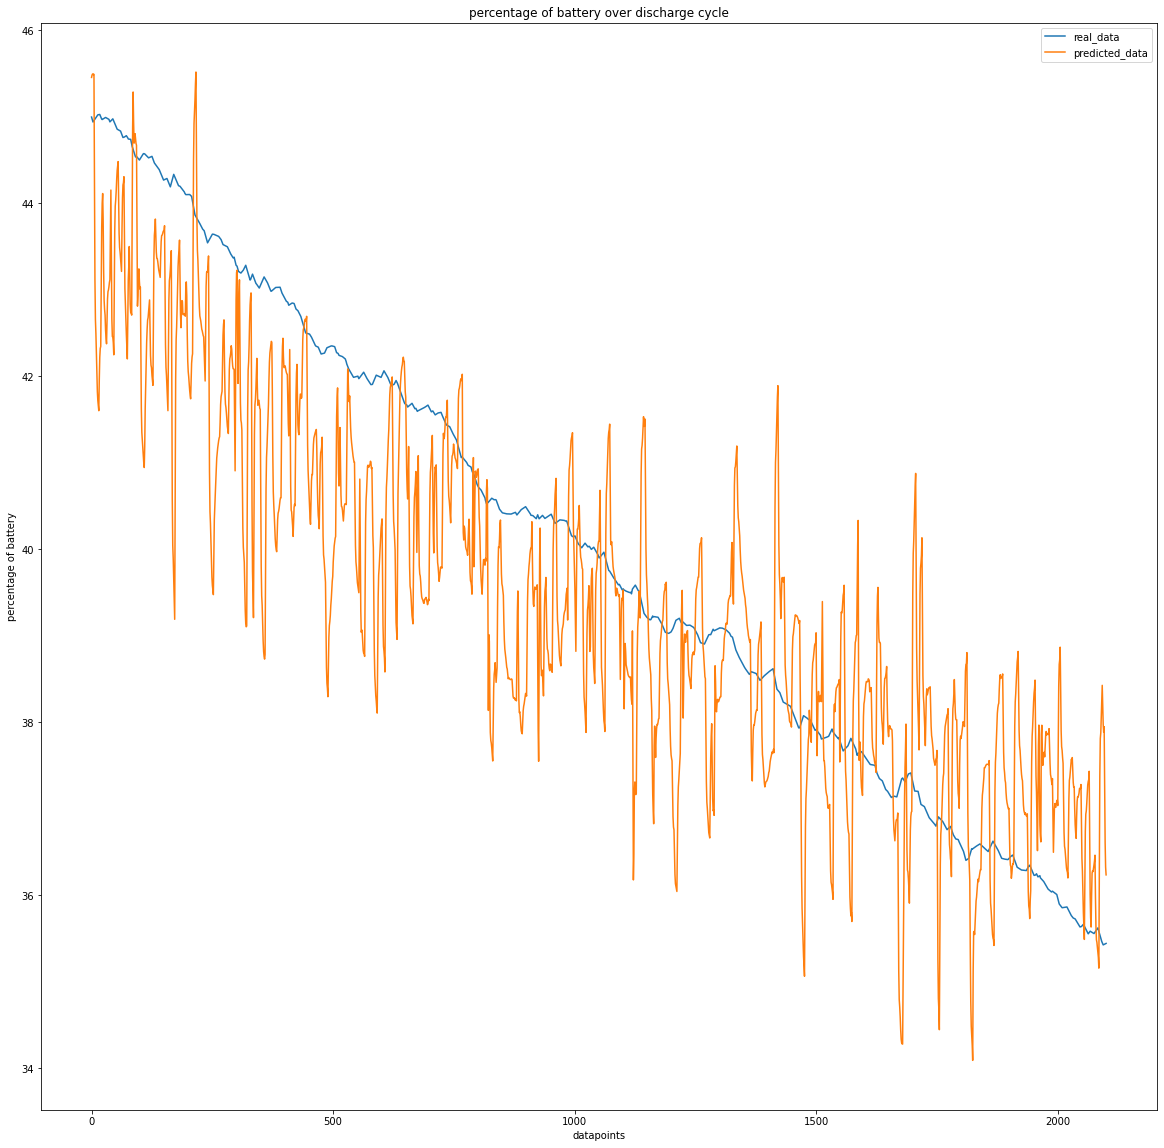

In [39]:
X = np.linspace(0,2100,2100)
plt.figure(figsize=(20,20))
plt.plot(X,results['y_true'][0:2100], label='real_data')
plt.plot(X,results['y_pred'][0:2100], label='predicted_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.show()

In [52]:
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 8 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator,epochs=5)

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
59903/59903 [==============================] - 416s 7ms/step - loss: 0.0118
Epoch 2/5
59903/59903 [==============================] - 356s 6ms/step - loss: 3.7881e-04
Epoch 4/5
59903/59903 [==============================] - 400s 7ms/step - loss: 2.9221e-04
Epoch 5/5
59903/59903 [==============================] - 413s 7ms/step - loss: 2.5757e-04


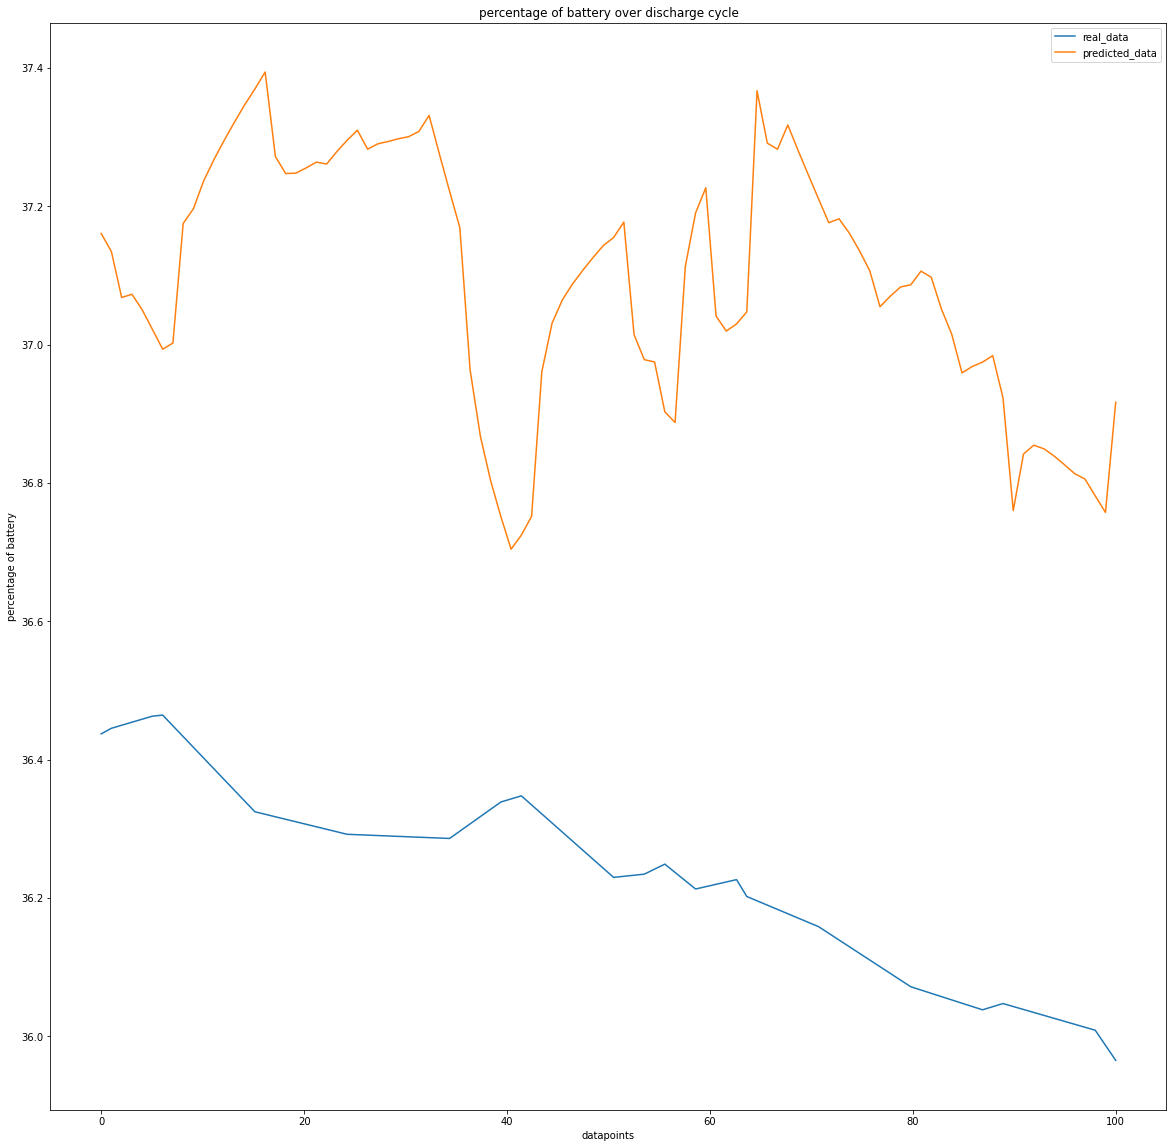

In [15]:
X = np.linspace(0,100,100)
plt.figure(figsize=(20,20))
plt.plot(X,results['y_true'][1900:2000], label='real_data')
plt.plot(X,results['y_pred'][1900:2000], label='predicted_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.show()

In [54]:
model.evaluate(test_generator)

6653/6653 [==============================] - 15s 2ms/step - loss: 0.2387


0.23867186903953552

In [34]:
from tensorflow.keras.layers import SimpleRNN
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

model = Sequential()
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator,epochs=5)

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
14976/14976 [==============================] - 67s 4ms/step - loss: 0.0956
Epoch 2/5
14976/14976 [==============================] - 61s 4ms/step - loss: 0.0020
Epoch 3/5
14976/14976 [==============================] - 61s 4ms/step - loss: 0.0016
Epoch 4/5
14976/14976 [==============================] - 61s 4ms/step - loss: 0.0014
Epoch 5/5
14976/14976 [==============================] - 61s 4ms/step - loss: 0.0012


In [51]:
model.evaluate(test_generator)

1664/1664 [==============================] - 3s 2ms/step - loss: 0.2244


0.22436721622943878

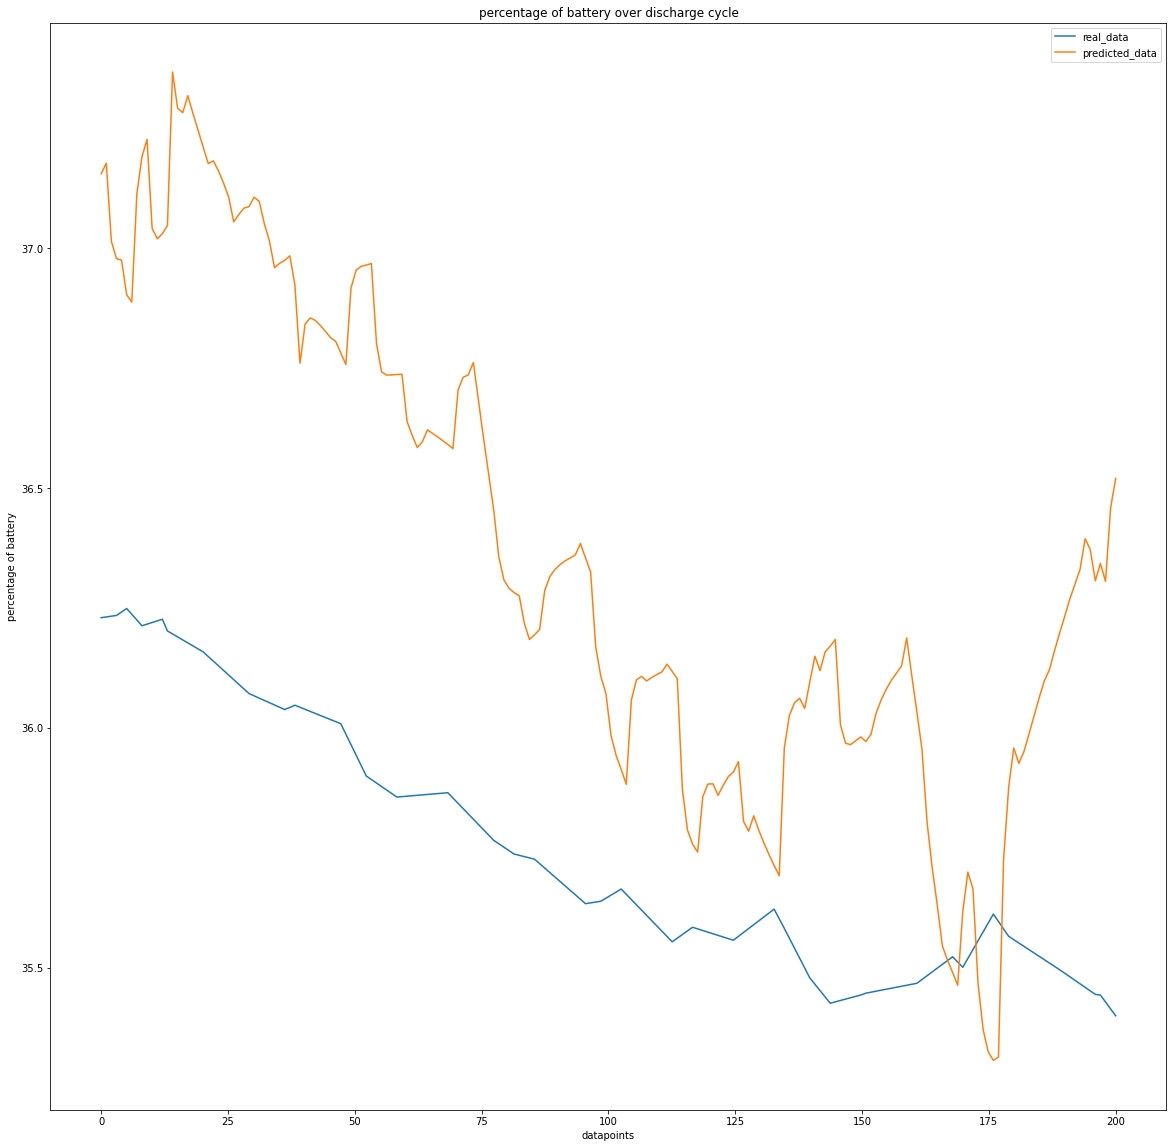

In [13]:
X = np.linspace(0,200,200)
plt.figure(figsize=(20,20))
plt.plot(X,results['y_true'][1950:2150], label='real_data')
plt.plot(X,results['y_pred'][1950:2150], label='predicted_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.show()

In [2]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt")))) # read data 
y_col='SOC_tot' # define y variable, i.e., what we want to predict

test_size = int(len(df) * 0.1) # here I ask that the test data will be 10% (0.1) of the entire data
train = df.iloc[:-test_size,:].copy() 
# Try using .loc[row_index,col_indexer] = value instead
test = df.iloc[-test_size:,:].copy()


X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() # the double brakets here are to keep the y in dataframe format, otherwise it will be pandas Series

Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.layers import GRU
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

model = Sequential()
model.add(GRU(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator,epochs=5)

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})

2021-10-04 16:55:45.332832: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-04 16:55:45.724554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
14976/14976 [==============================] - 99s 7ms/step - loss: 0.0011
Epoch 3/5
14976/14976 [==============================] - 98s 7ms/step - loss: 6.7360e-04
Epoch 4/5
14976/14976 [==============================] - 98s 7ms/step - loss: 4.3961e-04


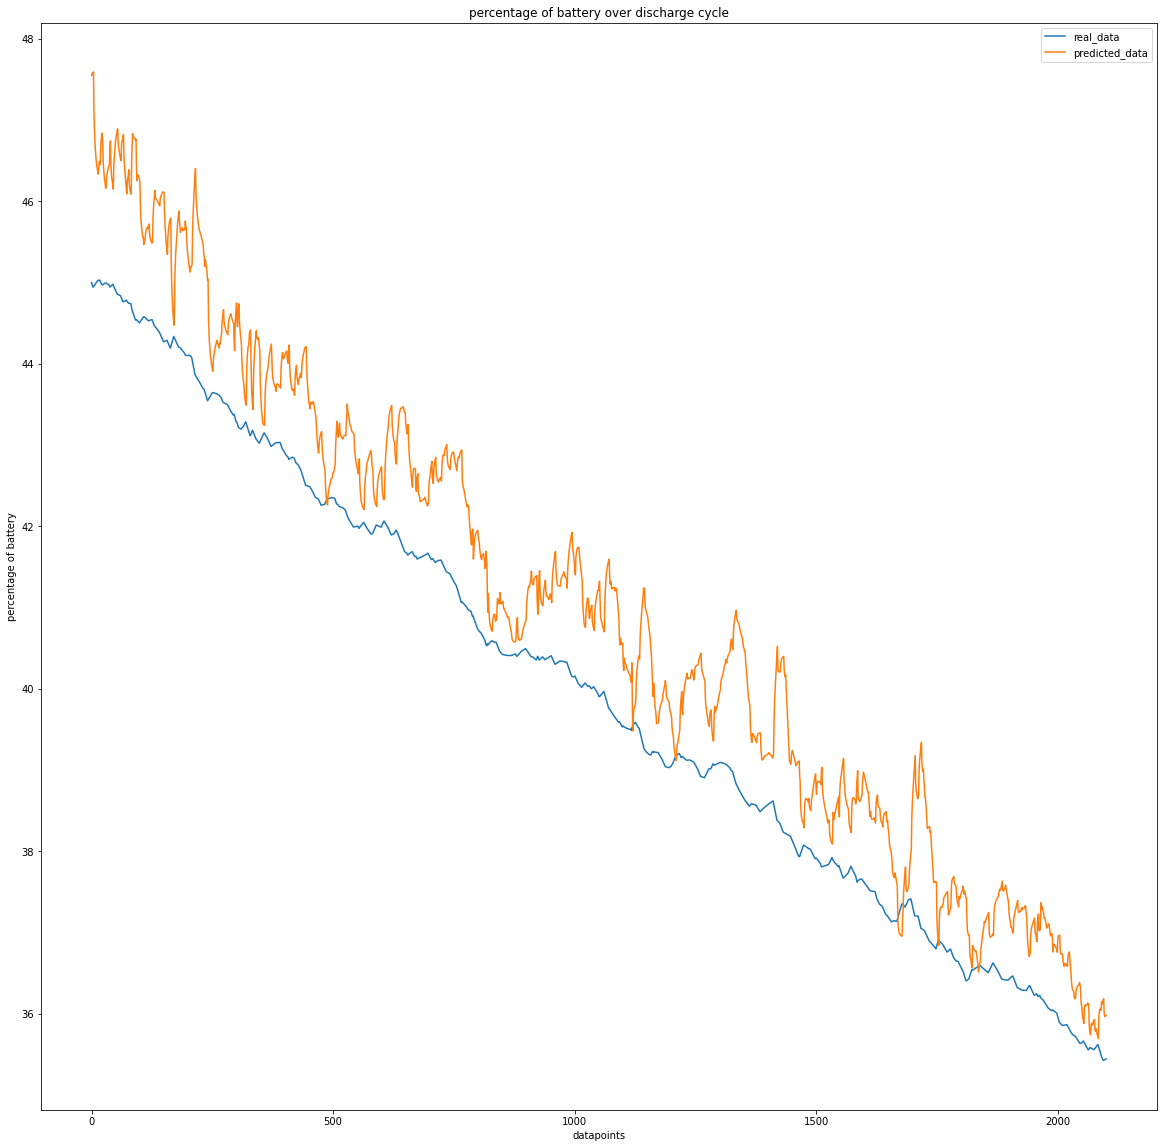

In [5]:
X = np.linspace(0,2100,2100)
plt.figure(figsize=(20,20))
plt.plot(X,results['y_true'][0:2100], label='real_data')
plt.plot(X,results['y_pred'][0:2100], label='predicted_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.show()

In [6]:
df.to_csv('../raw_data/test_data_automl.csv', index=False)

In [ ]:
df.to_csv('../raw_data/test_data_automl_train.csv', index=False)

In [7]:
len(df)

532498

In [9]:
df_train=df[:426998]
df_test=df[426998:]
df_train.to_csv('../raw_data/test_data_automl_train.csv', index=False)
df_test.to_csv('../raw_data/test_data_automl_test.csv', index=False)

In [ ]:
df_test=df[426998:]